<a href="https://colab.research.google.com/github/gopaltiwari04/LLPS-Score-Predicting-Protein-Phase-Separation-and-Biological-Function-from-Physicochemical-Features/blob/main/llps_vs_nonllps_classifier_btp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install standard libraries
!pip install pandas numpy scikit-learn matplotlib seaborn biopython gensim requests tqdm --quiet

# Install metapredict (Fast, robust IDR predictor)
!pip install metapredict --quiet

# Install NCBI BLAST+ and NCBI SEG (The specific tool needed for LCR)
print("Installing NCBI tools...")
!apt-get update -y -qq
!apt-get install -y ncbi-blast+ ncbi-seg -qq
print("Installation complete.")

import pandas as pd
import numpy as np
import os
import subprocess
import requests
import time
import math
from collections import Counter
from tqdm.notebook import tqdm

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

# Gensim for Word2Vec
from gensim.models import Word2Vec

# BioPython for sequence analysis
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Metapredict for IDR
import metapredict as meta

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("\nAll libraries imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 530.4 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 71.6 MB/s eta 0:00:00
Installing NCBI tools...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem 

In [ ]:
# ---------- CODE CELL: Upload, load, clean and combine datasets ----------

from google.colab import files
import os
import pandas as pd

# -- 1) Upload (if missing) --
required_files = ['llps_plus.csv', 'llps_minus.csv', 'pdb.csv']
missing = [f for f in required_files if not os.path.exists(f)]
if missing:
    print("Please upload the missing CSV files:", missing)
    uploaded = files.upload()
    # write any uploaded files to disk (Colab already does this, but safe to write)
    for fn, content in uploaded.items():
        with open(fn, 'wb') as fh:
            fh.write(content)
        print(f'User uploaded file "{fn}" ({len(content)} bytes)')
else:
    print("All required files already present in the environment.")

# -- 2) Load the CSVs into DataFrames --
try:
    df_plus = pd.read_csv('llps_plus.csv')
    df_minus = pd.read_csv('llps_minus.csv')
    df_pdb = pd.read_csv('pdb.csv')
    print(f"Loaded files: {len(df_plus)} rows (llps_plus), {len(df_minus)} rows (llps_minus), {len(df_pdb)} rows (pdb)")
except Exception as e:
    raise RuntimeError("Failed to read one or more CSV files. Check filenames and CSV format.") from e

# ---------- helper: sequence cleaning ----------
def clean_sequence(sequence):
    """
    Clean a protein sequence string:
      - keep only standard amino-acid one-letter codes (A,C,D,...,Y,U,O)
      - uppercase everything
      - return None if the resulting sequence is shorter than 11 residues
    """
    if not isinstance(sequence, str):
        return None
    valid_chars = set("ACDEFGHIKLMNPQRSTVWYUO")  # standard 20 + U and O
    cleaned = ''.join([c.upper() for c in sequence if c.upper() in valid_chars])
    return cleaned if len(cleaned) > 10 else None

# ---------- 3) Label and source columns (fixes you had) ----------
df_plus = df_plus.copy()
df_minus = df_minus.copy()
df_pdb = df_pdb.copy()

df_plus['Label']  = 1
df_plus['Source'] = 'llps_plus'

df_minus['Label'] = 0
df_minus['Source'] = 'llps_minus'

df_pdb['Label']   = 0
df_pdb['Source']  = 'pdb'

# ---------- 4) Concatenate ----------
df_combined = pd.concat([df_plus, df_minus, df_pdb], ignore_index=True)

# ---------- 5) Detect sequence column robustly ----------
# prefer 'Sequence' (case-sensitive), then case-insensitive matches, then any col containing 'seq'
candidate_cols = [c for c in df_combined.columns if c == 'Sequence' or c.lower() == 'sequence' or 'seq' in c.lower()]
if len(candidate_cols) == 0:
    raise KeyError("No sequence-like column found. Rename your sequence column to 'Sequence' or include 'seq' in the column name.")
sequence_column = candidate_cols[0]
print(f"Using column '{sequence_column}' as the sequence column.")

# ---------- 6) Create a cleaned sequence column and filter invalid sequences ----------
df_combined['Clean_Sequence'] = df_combined[sequence_column].astype(str).apply(clean_sequence)

before = len(df_combined)
df_combined.dropna(subset=['Clean_Sequence'], inplace=True)
after = len(df_combined)
print(f"Removed {before - after} rows with invalid or too-short sequences after cleaning.")

# ---------- 7) Remove duplicates (on cleaned sequence) ----------
before_dup = len(df_combined)
df_combined.drop_duplicates(subset=['Clean_Sequence'], inplace=True)
after_dup = len(df_combined)
print(f"Removed {before_dup - after_dup} duplicate sequences (based on Clean_Sequence).")

# ---------- 8) Finalize DataFrame for downstream steps ----------
# rename Clean_Sequence -> Sequence (so downstream code uses 'Sequence')
df_main = df_combined.copy()
df_main.rename(columns={'Clean_Sequence': 'Sequence'}, inplace=True)

# If you want to drop the original raw sequence column to avoid confusion:
if sequence_column != 'Sequence':
    # we already renamed Clean_Sequence to Sequence, so keep that and optionally drop original
    df_main.drop(columns=[sequence_column], errors='ignore', inplace=True)

# ---------- 9) Quick overview ----------
print("\nFinal dataset sample:")
display(df_main.head())

print("\nLabel distribution:")
print(df_main['Label'].value_counts())

print("\nNegative-class composition by source (Label==0):")
print(df_main[df_main['Label'] == 0]['Source'].value_counts())

# df_main is now ready for feature extraction / modeling


Please upload the missing CSV files: ['llps_plus.csv', 'llps_minus.csv', 'pdb.csv']


Saving pdb.csv to pdb.csv
Saving llps_minus.csv to llps_minus.csv
Saving llps_plus.csv to llps_plus.csv
User uploaded file "pdb.csv" (396343 bytes)
User uploaded file "llps_minus.csv" (24241 bytes)
User uploaded file "llps_plus.csv" (56430 bytes)
Loaded files: 137 rows (llps_plus), 84 rows (llps_minus), 1562 rows (pdb)
Using column 'Sequence' as the sequence column.
Removed 1562 rows with invalid or too-short sequences after cleaning.
Removed 0 duplicate sequences (based on Clean_Sequence).

Final dataset sample:


,Sequence,Uniprot_ID,Label,Source,PDB\tUniProt\tseq_len\tseq,Sequence
0,AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...,P05453,1,llps_plus,NaN,AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...
1,ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...,P35637,1,llps_plus,NaN,ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...
2,CLRKKRKPQAEKVDVIAGSSKMKGFSSSESESSSESSSSDSEDSET...,O60885,1,llps_plus,NaN,CLRKKRKPQAEKVDVIAGSSKMKGFSSSESESSSESSSSDSEDSET...
3,DFDVYVLAKLLGFASEELQEEIEIIRDNVTDAFEACKPLLKKLMIE...,G5EBV6,1,llps_plus,NaN,DFDVYVLAKLLGFASEELQEEIEIIRDNVTDAFEACKPLLKKLMIE...
4,EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPG...,Q15648,1,llps_plus,NaN,EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPG...



Label distribution:
Label
1    137
0     84
Name: count, dtype: int64

Negative-class composition by source (Label==0):
Source
llps_minus    84
Name: count, dtype: int64


In [ ]:
# (fixed) ----------
from tqdm.notebook import tqdm

def calculate_sequence_length(sequence):
    """Calculates the length of the sequence."""
    # Handle arrays/lists by converting to string or getting first element
    if isinstance(sequence, (list, np.ndarray)):
        if len(sequence) > 0:
            sequence = sequence[0] if isinstance(sequence, np.ndarray) else sequence[0]
        else:
            return 0
    return len(sequence) if isinstance(sequence, str) else 0

def calculate_hydrophobicity(sequence):
    if isinstance(sequence, (list, np.ndarray)):
        if len(sequence) > 0:
            sequence = sequence[0] if isinstance(sequence, np.ndarray) else sequence[0]
        else:
            return np.nan
    try:
        return ProteinAnalysis(sequence).gravy()
    except Exception:
        return np.nan  # handle potential errors for non-standard sequences

def calculate_shannon_entropy(sequence):
    """Calculates the Shannon entropy of the sequence."""
    # Handle arrays/lists
    if isinstance(sequence, (list, np.ndarray)):
        if len(sequence) > 0:
            sequence = sequence[0] if isinstance(sequence, np.ndarray) else sequence[0]
        else:
            return 0.0

    # Now check for empty/invalid sequences
    if sequence is None or not isinstance(sequence, str) or len(sequence) == 0:
        return 0.0

    counts = Counter(sequence)
    total_len = len(sequence)
    entropy = 0.0
    for count in counts.values():
        p_i = count / total_len
        entropy -= p_i * math.log2(p_i)
    return entropy

# Check for missing sequences
print(f"Total rows: {len(df_main)}")
print(f"Sample sequence type: {type(df_main['Sequence'].iloc[0])}")
print(f"Sample sequence value: {df_main['Sequence'].iloc[0]}")

# Apply these functions using .values to iterate over all rows (including NaN)
print("\nCalculating sequence lengths...")
df_main['Length'] = [calculate_sequence_length(seq) for seq in tqdm(df_main['Sequence'].values, desc="Length")]

print("Calculating hydrophobicity...")
df_main['Hydrophobicity'] = [calculate_hydrophobicity(seq) for seq in tqdm(df_main['Sequence'].values, desc="Hydrophobicity")]

print("Calculating Shannon entropy...")
df_main['ShannonEntropy'] = [calculate_shannon_entropy(seq) for seq in tqdm(df_main['Sequence'].values, desc="Shannon Entropy")]

print("\nGlobal features calculated:")
display(df_main[['Sequence', 'Length', 'Hydrophobicity', 'ShannonEntropy']].head(10))

Total rows: 221
Sample sequence type: <class 'pandas.core.series.Series'>
Sample sequence value: Sequence    AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...
Sequence    AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...
Name: 0, dtype: object

Calculating sequence lengths...


Length:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating hydrophobicity...


Hydrophobicity:   0%|          | 0/221 [00:00<?, ?it/s]

Calculating Shannon entropy...


Shannon Entropy:   0%|          | 0/221 [00:00<?, ?it/s]


Global features calculated:


,Sequence,Sequence,Length,Hydrophobicity,ShannonEntropy
0,AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...,AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...,571,-0.559895,4.086236
1,ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...,ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...,213,-1.453521,2.734151
2,CLRKKRKPQAEKVDVIAGSSKMKGFSSSESESSSESSSSDSEDSET...,CLRKKRKPQAEKVDVIAGSSKMKGFSSSESESSSESSSSDSEDSET...,678,-1.237316,3.669713
3,DFDVYVLAKLLGFASEELQEEIEIIRDNVTDAFEACKPLLKKLMIE...,DFDVYVLAKLLGFASEELQEEIEIIRDNVTDAFEACKPLLKKLMIE...,529,-0.368242,4.023415
4,EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPG...,EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPG...,627,-1.131419,3.593170
5,EPADPFISLLMDPLEESVGKVVNHIAQLFEEASKNEGDESLVLRSQ...,EPADPFISLLMDPLEESVGKVVNHIAQLFEEASKNEGDESLVLRSQ...,516,-0.487597,4.034462
6,ESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRG...,ESNQSNNGGSGNAALNRGGRYVPPHLRGGDGGAAAAASAGGDDRRG...,167,-1.728144,2.886690
7,FSPTSPTYSPTSPAYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPT...,FSPTSPTYSPTSPAYSPTSPSYSPTSPSYSPTSPSYSPTSPSYSPT...,192,-1.205729,2.472315
8,GPLGSMEDSMDMDMSPLRPQNYLFGCELKADKDYHFKVDNDENEHQ...,GPLGSMEDSMDMDMSPLRPQNYLFGCELKADKDYHFKVDNDENEHQ...,245,-1.028571,3.931549
9,GRFGGNPGGFGNQGGFGNSRGGGAGLGNNQGSNMGGGMNFGAFSIN...,GRFGGNPGGFGNQGGFGNSRGGGAGLGNNQGSNMGGGMNFGAFSIN...,141,-0.607092,3.231182


In [ ]:
# Install the Python library for IDR prediction
!pip install metapredict --quiet

# Install the system tool for LCR (SEG)
!apt-get update -y -qq
!apt-get install -y ncbi-seg -qq

print("Installation complete.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Installation complete.


In [ ]:
import pandas as pd
import shutil
import subprocess
import os
import metapredict as meta
from tqdm.notebook import tqdm

# --- STEP 1: Fix Duplicate "Sequence" Columns ---
# Check if 'Sequence' is duplicated (returns a DataFrame instead of Series)
if isinstance(df_main['Sequence'], pd.DataFrame):
    print("⚠️ Duplicate 'Sequence' columns detected. Fixing...")

    # We take the *last* column named 'Sequence' (usually the cleaned one)
    real_sequences = df_main['Sequence'].iloc[:, -1].copy()

    # Drop all columns named 'Sequence' to reset
    df_main = df_main.loc[:, df_main.columns != 'Sequence']

    # Add back the single correct column
    df_main['Sequence'] = real_sequences
    print("✅ DataFrame fixed. 'Sequence' is now unique.")
else:
    print("✅ 'Sequence' column is already unique.")

# --- STEP 2: Define Functions ---

def calculate_lcr_fraction(sequence, seq_id="temp_seq"):
    if not isinstance(sequence, str) or len(sequence) == 0:
        return 0.0

    # Locate seg tool
    seg_command = "seg"
    if shutil.which("seg") is None:
        if shutil.which("ncbi-seg") is not None:
            seg_command = "ncbi-seg"
        else:
            # Fallback: if seg is missing, return 0.0 (or raise error)
            return 0.0

    fasta_in = f"{seq_id}.fasta"
    fasta_out = f"{seq_id}.seg.fasta"

    try:
        with open(fasta_in, "w") as f:
            f.write(f">{seq_id}\n{sequence}\n")

        # Run SEG
        subprocess.run(f"{seg_command} {fasta_in} -x > {fasta_out}",
                       shell=True, check=True, stderr=subprocess.DEVNULL)

        with open(fasta_out, "r") as f:
            lines = f.readlines()
            masked = "".join(line.strip() for line in lines if not line.startswith('>'))

        return masked.lower().count('x') / len(sequence)

    except Exception:
        return 0.0
    finally:
        if os.path.exists(fasta_in): os.remove(fasta_in)
        if os.path.exists(fasta_out): os.remove(fasta_out)

def calculate_idr_fraction(sequence):
    if not isinstance(sequence, str) or len(sequence) == 0:
        return 0.0
    try:
        scores = meta.predict_disorder(sequence)
        return sum(1 for s in scores if s > 0.5) / len(sequence)
    except:
        return 0.0

# --- STEP 3: Run Calculations ---

print("\nCalculating LCR Fraction...")
df_main['LCR_Fraction'] = [
    calculate_lcr_fraction(seq, f"seq_{i}")
    for i, seq in tqdm(enumerate(df_main['Sequence'].values), total=len(df_main))
]

print("\nCalculating IDR Fraction...")
df_main['IDR_Fraction'] = [
    calculate_idr_fraction(seq)
    for seq in tqdm(df_main['Sequence'].values, total=len(df_main))
]

# --- STEP 4: Inspect Results ---
print("\nResults Sample:")
display(df_main[['Sequence', 'LCR_Fraction', 'IDR_Fraction']].head())

⚠️ Duplicate 'Sequence' columns detected. Fixing...
✅ DataFrame fixed. 'Sequence' is now unique.

Calculating LCR Fraction...


  0%|          | 0/221 [00:00<?, ?it/s]


Calculating IDR Fraction...


  0%|          | 0/221 [00:00<?, ?it/s]


Results Sample:


,Sequence,LCR_Fraction,IDR_Fraction
0,AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...,0.148862,0.246935
1,ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...,0.924883,1.000000
2,CLRKKRKPQAEKVDVIAGSSKMKGFSSSESESSSESSSSDSEDSET...,0.529499,0.994100
3,DFDVYVLAKLLGFASEELQEEIEIIRDNVTDAFEACKPLLKKLMIE...,0.189036,0.470699
4,EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPG...,0.397129,1.000000


Checking for required files...
✅ Found llps_plus.csv
✅ Found llps_minus.csv
✅ Found pdb.csv

Loading datasets...
Total sequences loaded: 1783
Calculating features...


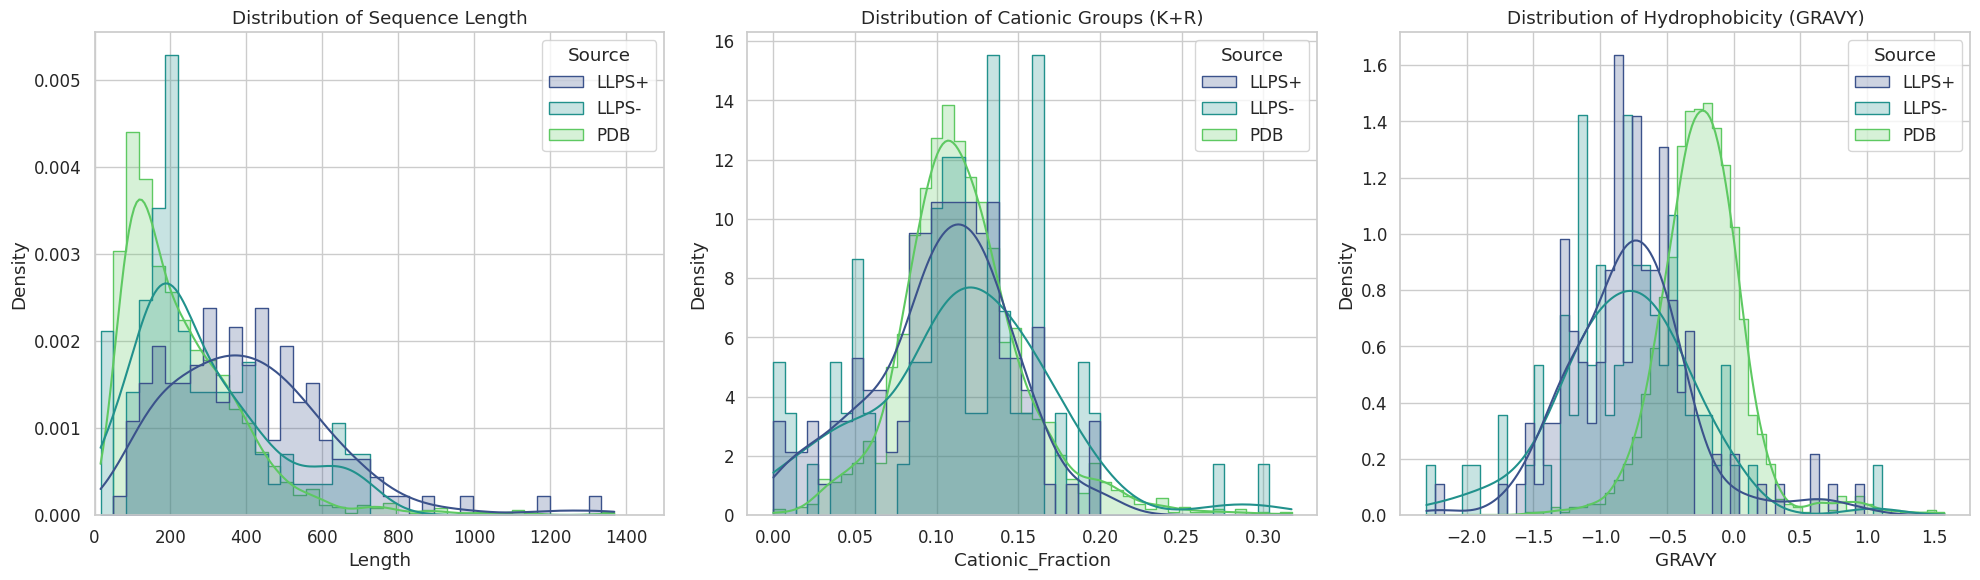

In [ ]:
# @title Install Dependencies and Import Libraries
!pip install biopython seaborn matplotlib pandas numpy --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from google.colab import files
import os
import io

# Set the visual style
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)

# --------------------------------------------------------------------------------
# 1. CHECK AND UPLOAD FILES
# --------------------------------------------------------------------------------
required_files = ['llps_plus.csv', 'llps_minus.csv', 'pdb.csv']
uploaded_data = {}

print("Checking for required files...")
for filename in required_files:
    if os.path.exists(filename):
        print(f"✅ Found {filename}")
    else:
        print(f"⚠️ {filename} is missing. Please upload it now.")
        uploaded = files.upload()
        for name, content in uploaded.items():
            # Save the uploaded file to disk so pandas can read it
            with open(name, 'wb') as f:
                f.write(content)
            print(f"✅ Uploaded {name}")

# --------------------------------------------------------------------------------
# 2. LOAD DATASETS
# --------------------------------------------------------------------------------
print("\nLoading datasets...")

def load_csv_safe(filename, source_label, sep=','):
    try:
        df = pd.read_csv(filename, sep=sep)
        df['Source'] = source_label
        # Standardize sequence column name
        if 'seq' in df.columns:
            df.rename(columns={'seq': 'Sequence'}, inplace=True)
        return df
    except Exception as e:
        print(f"❌ Error loading {filename}: {e}")
        return pd.DataFrame(columns=['Sequence', 'Source'])

df_plus = load_csv_safe('llps_plus.csv', 'LLPS+')
df_minus = load_csv_safe('llps_minus.csv', 'LLPS-')
df_pdb = load_csv_safe('pdb.csv', 'PDB', sep='\t') # pdb.csv is often tab-separated

# Combine datasets
df_combined = pd.concat([df_plus, df_minus, df_pdb], ignore_index=True)
print(f"Total sequences loaded: {len(df_combined)}")

# --------------------------------------------------------------------------------
# 3. FEATURE CALCULATION
# --------------------------------------------------------------------------------
def calculate_physicochemical_properties(seq):
    if not isinstance(seq, str) or len(seq) == 0:
        return pd.Series([np.nan, np.nan, np.nan])

    seq = seq.upper()
    standard_aas = set("ACDEFGHIKLMNPQRSTVWY")
    cleaned_seq = "".join([aa for aa in seq if aa in standard_aas])

    if len(cleaned_seq) == 0:
        return pd.Series([0, 0, np.nan])

    length = len(cleaned_seq)
    num_cationic = cleaned_seq.count('K') + cleaned_seq.count('R')
    cationic_fraction = num_cationic / length

    try:
        X = ProteinAnalysis(cleaned_seq)
        gravy = X.gravy()
    except:
        gravy = np.nan

    return pd.Series([length, cationic_fraction, gravy])

print("Calculating features...")
if not df_combined.empty:
    df_combined[['Length', 'Cationic_Fraction', 'GRAVY']] = df_combined['Sequence'].apply(calculate_physicochemical_properties)
    df_combined.dropna(subset=['Length', 'GRAVY'], inplace=True)

# --------------------------------------------------------------------------------
# 4. PLOTTING
# --------------------------------------------------------------------------------
if not df_combined.empty:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot A: Sequence Length
    sns.histplot(data=df_combined, x="Length", hue="Source", element="step", stat="density", common_norm=False, kde=True, ax=axes[0], palette="viridis")
    axes[0].set_title('Distribution of Sequence Length')
    axes[0].set_xlim(0, 1500)

    # Plot B: Cationic Groups
    sns.histplot(data=df_combined, x="Cationic_Fraction", hue="Source", element="step", stat="density", common_norm=False, kde=True, ax=axes[1], palette="viridis")
    axes[1].set_title('Distribution of Cationic Groups (K+R)')

    # Plot C: Hydrophobicity (GRAVY)
    sns.histplot(data=df_combined, x="GRAVY", hue="Source", element="step", stat="density", common_norm=False, kde=True, ax=axes[2], palette="viridis")
    axes[2].set_title('Distribution of Hydrophobicity (GRAVY)')

    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

In [ ]:
import subprocess
import os
import shutil
import numpy as np
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm

# 1. Define the specific groups from Saar et al. 2021 (Methods section)
AA_GROUPS = {
    'Polar': set("SQNGCTP"),
    'Hydrophobic': set("AILMFV"),
    'Aromatic': set("WYF"),
    'Cationic': set("KRH"),
    'Anionic': set("DE")
}

def analyze_lcr_properties(sequence, seq_id="temp"):
    """
    Runs SEG to find LCRs, then calculates the fraction of specific
    amino acid groups WITHIN those LCRs (as per Saar et al. 2021).
    """
    if not isinstance(sequence, str) or len(sequence) == 0:
        return pd.Series([0.0]*6, index=['LCR_Fraction', 'LCR_Polar', 'LCR_Hydrophobic', 'LCR_Aromatic', 'LCR_Cationic', 'LCR_Anionic'])

    # Write to file
    fasta_in = f"{seq_id}.fasta"
    fasta_out = f"{seq_id}.seg.fasta"
    with open(fasta_in, "w") as f:
        f.write(f">{seq_id}\n{sequence}\n")

    # Run SEG with -x to get the mask
    # We need to know WHERE the LCRs are to analyze their content
    seg_cmd = "seg" if shutil.which("seg") else "ncbi-seg"

    try:
        subprocess.run(f"{seg_cmd} {fasta_in} -x > {fasta_out}",
                       shell=True, check=True, stderr=subprocess.DEVNULL)

        with open(fasta_out, "r") as f:
            lines = f.readlines()
            # Reconstruct masked sequence (removing header)
            masked_seq = "".join(line.strip() for line in lines if not line.startswith('>'))

        # Safety check: lengths must match
        if len(masked_seq) != len(sequence):
            return pd.Series([0.0]*6)

        # Extract ONLY the residues that correspond to 'x' in the mask
        # This gives us the actual amino acid sequence of the LCRs
        lcr_residues = [original_aa for original_aa, mask_char in zip(sequence, masked_seq) if mask_char.lower() == 'x']

        lcr_len = len(lcr_residues)
        total_len = len(sequence)

        # 1. LCR Fraction (Global)
        lcr_fraction = lcr_len / total_len if total_len > 0 else 0.0

        # 2. Composition INSIDE LCRs
        # If no LCRs exist, these fractions are 0
        if lcr_len == 0:
            feats = [0.0] * 5
        else:
            # Count occurrence of each group in the LCR residues
            feats = []
            for name, group_set in AA_GROUPS.items():
                count = sum(1 for aa in lcr_residues if aa.upper() in group_set)
                feats.append(count / lcr_len) # Fraction relative to LCR length

        return pd.Series([lcr_fraction] + feats,
                         index=['LCR_Fraction', 'LCR_Polar', 'LCR_Hydrophobic', 'LCR_Aromatic', 'LCR_Cationic', 'LCR_Anionic'])

    except Exception as e:
        return pd.Series([0.0]*6)
    finally:
        if os.path.exists(fasta_in): os.remove(fasta_in)
        if os.path.exists(fasta_out): os.remove(fasta_out)

# Apply to dataframe
print("Analyzing LCR Composition (Saar et al. Methodology)...")
lcr_features = df_combined['Sequence'].apply(lambda s: analyze_lcr_properties(s))
df_combined = pd.concat([df_combined, lcr_features], axis=1)

print("\nNew Features Extracted:")
display(df_combined[['Sequence', 'LCR_Fraction', 'LCR_Polar', 'LCR_Cationic']].head())

Analyzing LCR Composition (Saar et al. Methodology)...

New Features Extracted:


,Sequence,LCR_Fraction,LCR_Polar,LCR_Cationic
0,AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...,0.148862,0.270588,0.223529
1,ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...,0.924883,0.842640,0.005076
2,CLRKKRKPQAEKVDVIAGSSKMKGFSSSESESSSESSSSDSEDSET...,0.529499,0.582173,0.122563
3,DFDVYVLAKLLGFASEELQEEIEIIRDNVTDAFEACKPLLKKLMIE...,0.189036,0.620000,0.140000
4,EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPG...,0.397129,0.614458,0.228916


In [ ]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# ------------------------------------------------------------------------------
# 1. TOKENIZATION FUNCTION (Overlapping 3-grams)
# ------------------------------------------------------------------------------
def get_3grams(sequence):
    """
    Splits a protein sequence into overlapping 3-grams.
    Example: "MKTVA" -> ["MKT", "KTV", "TVA"]
    """
    if not isinstance(sequence, str) or len(sequence) < 3:
        return []
    return [sequence[i:i+3] for i in range(len(sequence) - 2)]

# ------------------------------------------------------------------------------
# 2. TRAIN WORD2VEC MODEL
# ------------------------------------------------------------------------------
# Prepare the "corpus" (sentences) for the language model
print("Tokenizing sequences for Word2Vec training...")
corpus = [get_3grams(seq) for seq in df_combined['Sequence']]

# Filter out empty sequences
corpus = [sent for sent in corpus if sent]

print(f"Training Word2Vec model on {len(corpus)} sequences...")
# Parameters from Saar et al. (2021):
# - vector_size=200
# - window=25
# - sg=1 (Skip-gram)
w2v_model = Word2Vec(
    sentences=corpus,
    vector_size=200,
    window=25,
    min_count=1,  # Ensure we capture all 3-grams in this dataset
    workers=4,
    sg=1,         # Skip-gram algorithm
    epochs=30     # Higher epochs since our dataset is small compared to SwissProt
)
print("✅ Word2Vec model trained successfully.")

# ------------------------------------------------------------------------------
# 3. GENERATE EMBEDDINGS (Summing Vectors)
# ------------------------------------------------------------------------------
def get_protein_embedding(sequence, model):
    """
    Converts a protein sequence into a single 200-dimensional vector
    by SUMMING the vectors of its constituent 3-grams.
    """
    grams = get_3grams(sequence)

    # If sequence is too short or empty, return zero vector
    if not grams:
        return np.zeros(model.vector_size)

    # Retrieve vectors for each 3-gram
    vectors = []
    for gram in grams:
        if gram in model.wv:
            vectors.append(model.wv[gram])

    if not vectors:
        return np.zeros(model.vector_size)

    # SUM the vectors (as per Saar et al. Methods)
    return np.sum(vectors, axis=0)

print("Generating embedding vectors for all proteins...")
# Create a list of arrays, then stack them
embedding_list = [get_protein_embedding(seq, w2v_model) for seq in df_combined['Sequence']]
X_embeddings = np.vstack(embedding_list)

# Convert to DataFrame for easier handling later
# Naming columns 'dim_0' to 'dim_199'
embedding_cols = [f'dim_{i}' for i in range(200)]
df_embeddings = pd.DataFrame(X_embeddings, columns=embedding_cols, index=df_combined.index)

# Combine with main dataframe
df_final = pd.concat([df_combined, df_embeddings], axis=1)

print(f"\n✅ Generated Embeddings matrix shape: {X_embeddings.shape}")
display(df_final[['Sequence'] + embedding_cols[:5]].head()) # Show first 5 dimensions

Tokenizing sequences for Word2Vec training...
Training Word2Vec model on 1783 sequences...
✅ Word2Vec model trained successfully.
Generating embedding vectors for all proteins...

✅ Generated Embeddings matrix shape: (1783, 200)


,Sequence,dim_0,dim_1,dim_2,dim_3,dim_4
0,AGFQPQSQGMSLNDFQKQQKQAAPKPKKTLKLVSSSGIKLANATKK...,24.738192,81.692116,33.696369,91.848747,-34.931648
1,ASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDT...,34.320042,31.937466,-11.370069,4.049866,20.560722
2,CLRKKRKPQAEKVDVIAGSSKMKGFSSSESESSSESSSSDSEDSET...,129.721085,53.527412,-3.131293,110.798393,50.717682
3,DFDVYVLAKLLGFASEELQEEIEIIRDNVTDAFEACKPLLKKLMIE...,35.571297,70.040489,7.061574,73.640320,0.172414
4,EHHSGSQGPLLTTGDLGKEKTQKRVKEGNGTSNSTLSGPGLDSKPG...,58.198715,81.158585,3.523273,28.592594,27.754160


In [ ]:
import pandas as pd
import numpy as np
import metapredict as meta
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from collections import Counter
from tqdm.notebook import tqdm

# 1. Define calculation functions for the missing features
def calculate_shannon_entropy(seq):
    """Calculates Shannon Entropy (measure of sequence complexity)."""
    if not seq or pd.isna(seq): return 0.0
    seq = seq.upper()
    L = len(seq)
    counts = Counter(seq)
    entropy = 0.0
    for count in counts.values():
        p = count / L
        entropy -= p * np.log2(p)
    return entropy

def calculate_hydrophobicity_sum(seq):
    """
    Calculates SUM of hydrophobicity (Kyte-Doolittle) as per Saar et al. paper.
    (Note: The paper uses Sum, not Average/GRAVY).
    """
    if not seq or pd.isna(seq): return 0.0
    # KD Scale
    kd = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
          'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
          'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
          'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}
    return sum(kd.get(aa.upper(), 0) for aa in seq)

def calculate_idr_fraction(seq):
    """Calculates fraction of disordered residues using Metapredict."""
    if not seq or pd.isna(seq): return 0.0
    try:
        scores = meta.predict_disorder(seq)
        return sum(1 for s in scores if s > 0.5) / len(seq)
    except:
        return 0.0

# 2. Apply calculations to df_final
print("Repairing DataFrame... calculating missing features.")

# Ensure Sequence column is clean
df_final = df_final.loc[:, ~df_final.columns.duplicated()] # Remove duplicate cols if any

# A. Label (derived from Source if Label is missing)
if 'Label' not in df_final.columns:
    print("- Creating 'Label' column from 'Source'...")
    # Map: LLPS+ is 1, everything else (LLPS-, PDB) is 0
    df_final['Label'] = df_final['Source'].apply(lambda x: 1 if x == 'LLPS+' else 0)

# B. Hydrophobicity (Sum)
if 'Hydrophobicity' not in df_final.columns:
    print("- Calculating Hydrophobicity (Sum)...")
    df_final['Hydrophobicity'] = df_final['Sequence'].apply(calculate_hydrophobicity_sum)

# C. Shannon Entropy
if 'ShannonEntropy' not in df_final.columns:
    print("- Calculating Shannon Entropy...")
    df_final['ShannonEntropy'] = df_final['Sequence'].apply(calculate_shannon_entropy)

# D. IDR Fraction
if 'IDR_Fraction' not in df_final.columns:
    print("- Calculating IDR Fraction (this might take a minute)...")
    df_final['IDR_Fraction'] = [calculate_idr_fraction(seq) for seq in tqdm(df_final['Sequence'], desc="IDR")]

# E. Length (ensure it exists)
if 'Length' not in df_final.columns:
    df_final['Length'] = df_final['Sequence'].apply(len)

print("\n✅ DataFrame repaired. Missing columns added.")
print("You can now run Step 3 (Training).")

Repairing DataFrame... calculating missing features.
- Creating 'Label' column from 'Source'...
- Calculating Hydrophobicity (Sum)...
- Calculating Shannon Entropy...
- Calculating IDR Fraction (this might take a minute)...


IDR:   0%|          | 0/1783 [00:00<?, ?it/s]


✅ DataFrame repaired. Missing columns added.
You can now run Step 3 (Training).


Training Data: 1426 sequences
Testing Data:  357 sequences

Training Random Forest Classifier...
✅ Model trained.

--- Model Performance ---
Accuracy: 0.9468
ROC AUC:  0.9758

Classification Report:
              precision    recall  f1-score   support

    Non-LLPS       0.96      0.99      0.97       330
       LLPS+       0.75      0.44      0.56        27

    accuracy                           0.95       357
   macro avg       0.85      0.72      0.76       357
weighted avg       0.94      0.95      0.94       357



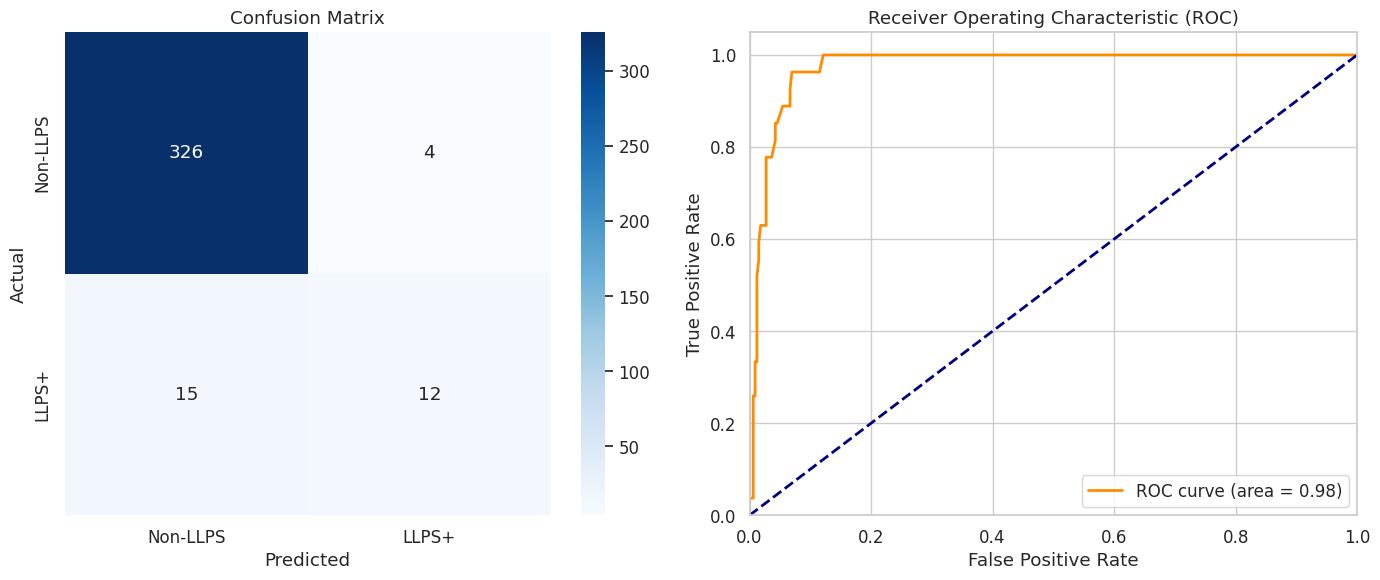

1. Hydrophobicity (0.0437)
2. dim_171 (0.0313)
3. IDR_Fraction (0.0308)
4. LCR_Fraction (0.0271)
5. dim_157 (0.0267)
6. dim_137 (0.0230)
7. dim_167 (0.0221)
8. dim_130 (0.0216)
9. dim_125 (0.0203)
10. dim_199 (0.0200)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# 1. PREPARE DATA
# ------------------------------------------------------------------------------
# Define the list of features to use for training
# We combine the Biophysical Features (EF) with the Language Model Embeddings (LM)
ef_features = [
    'Length', 'Hydrophobicity', 'ShannonEntropy',
    'LCR_Fraction', 'IDR_Fraction',
    'LCR_Polar', 'LCR_Hydrophobic', 'LCR_Aromatic', 'LCR_Cationic', 'LCR_Anionic'
]
lm_features = [f'dim_{i}' for i in range(200)] # The 200 dimensions from Word2Vec

feature_cols = ef_features + lm_features

# Drop any rows that might still have NaNs (just in case)
df_model = df_final.dropna(subset=feature_cols + ['Label']).copy()

X = df_model[feature_cols]
y = df_model['Label'].astype(int) # 1 for LLPS+, 0 for Non-LLPS

# Split into Training and Testing sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Data: {X_train.shape[0]} sequences")
print(f"Testing Data:  {X_test.shape[0]} sequences")

# ------------------------------------------------------------------------------
# 2. TRAIN MODEL
# ------------------------------------------------------------------------------
print("\nTraining Random Forest Classifier...")
# Parameters similar to standard baseline (100 trees)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("✅ Model trained.")

# ------------------------------------------------------------------------------
# 3. EVALUATE PERFORMANCE
# ------------------------------------------------------------------------------
# Make predictions
y_pred = rf_model.predict(X_test)
y_probs = rf_model.predict_proba(X_test)[:, 1] # Probability of being LLPS+

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print(f"\n--- Model Performance ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC:  {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-LLPS', 'LLPS+']))

# ------------------------------------------------------------------------------
# 4. VISUALIZE RESULTS
# ------------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot A: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-LLPS', 'LLPS+'], yticklabels=['Non-LLPS', 'LLPS+'])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Plot B: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC)')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 5. FEATURE IMPORTANCE (Which features matter most?)
# ------------------------------------------------------------------------------
# Sort features by importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(10):
    feat_name = feature_cols[indices[i]]
    print(f"{i+1}. {feat_name} ({importances[indices[i]]:.4f})")